In [41]:
# main.py – orchestrateur du pipeline complet d'expérimentation

# 📦 Imports standards
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

sys.path.append(os.path.abspath("../src"))

# 🧠 Imports personnalisés (modules locaux à ton projet)
from models.RF import train_evaluate_rf
from models.DNN import train_evaluate_mlp
from evaluation.metrics import get_metrics
from evaluation.visualization import plot_bar_metrics, plot_heatmap, plot_radar

# 📁 Dictionnaire contenant les chemins des datasets
DATASETS = {
    "KNN": "C:/Users/bamoi/OneDrive - Groupe ESAIP/$ PSIR/experimentation/repo/psir-ml-imputation/src/imputation/hta_impute_KNN.csv",
    "MICE": "C:/Users/bamoi/OneDrive - Groupe ESAIP/$ PSIR/experimentation/repo/psir-ml-imputation/src/imputation/hta_impute_MICE.csv",
    "SMOTE": {
        "train": "C:/Users/bamoi/OneDrive - Groupe ESAIP/$ PSIR/experimentation/repo/psir-ml-imputation/src/imputation/train_SMOTE_MICE.csv",
        "test": "C:/Users/bamoi/OneDrive - Groupe ESAIP/$ PSIR/experimentation/repo/psir-ml-imputation/src/imputation/test_original_MICE.csv"
    }
}

# 🔍 Dictionnaire des modèles que l’on veut tester
MODELES = {
    "Random Forest": train_evaluate_rf,
    "MLP": train_evaluate_mlp
}


# 🔁 Fonction d’encodage One-Hot cohérent train/test
def one_hot_encode_train_test(X_train, X_test):
    cat_cols = X_train.select_dtypes(include="object").columns.tolist()
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoder.fit(X_train[cat_cols])

    X_train_encoded = encoder.transform(X_train[cat_cols])
    X_test_encoded = encoder.transform(X_test[cat_cols])
    encoded_col_names = encoder.get_feature_names_out(cat_cols)

    X_train_num = X_train.drop(columns=cat_cols).reset_index(drop=True)
    X_test_num = X_test.drop(columns=cat_cols).reset_index(drop=True)

    X_train_final = pd.concat([
        X_train_num,
        pd.DataFrame(X_train_encoded, columns=encoded_col_names)
    ], axis=1)

    X_test_final = pd.concat([
        X_test_num,
        pd.DataFrame(X_test_encoded, columns=encoded_col_names)
    ], axis=1)

    return X_train_final, X_test_final


# 📊 Cette fonction applique tous les modèles à un jeu de données
# 🎯 Fonction principale de test
def tester_pipeline(imputation_name, df_train, df_test):
    X_train = df_train.drop("HTA", axis=1)
    y_train = df_train["HTA"]
    X_test = df_test.drop("HTA", axis=1)
    y_test = df_test["HTA"]

    # ✅ Encodage uniquement si des colonnes 'object' sont présentes
    if X_train.select_dtypes(include='object').shape[1] > 0:
        X_train, X_test = one_hot_encode_train_test(X_train, X_test)

    resultats_locaux = []
    for nom_modele, fonction in MODELES.items():
        print(f"\n⚙️  Test en cours : Imputation = {imputation_name}, Modèle = {nom_modele}")
        scores = fonction(X_train, y_train, X_test, y_test)
        scores.update({
            "Imputation": imputation_name,
            "Modèle": nom_modele
        })
        resultats_locaux.append(scores)

    return resultats_locaux



In [42]:
# 📊 Fonction principale d’exécution du pipeline complet
def executer_experimentation():
    """
    Lance l’expérimentation complète :
    - charge les datasets
    - applique les modèles
    - collecte et sauvegarde les résultats
    """
    resultats = []

    # 🔁 1. Traitement des jeux de données KNN et MICE
    for methode in ["KNN", "MICE"]:
        chemin = DATASETS[methode]
        print(f"\n📁 Chargement du dataset {methode} : {chemin}")
        df = pd.read_csv(chemin)

        # Séparation X / y + split 80/20 stratifié
        X = df.drop(columns=["HTA"])
        y = df["HTA"]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        df_train = X_train.copy()
        df_train["HTA"] = y_train
        df_test = X_test.copy()
        df_test["HTA"] = y_test

        # Evaluation des modèles sur ce dataset
        resultats += tester_pipeline(methode, df_train, df_test)

    # 🔁 2. Traitement spécifique du cas SMOTE (train/test prédéfinis)
    print(f"\n📁 Chargement des fichiers SMOTE (train/test)")
    df_train_smote = pd.read_csv(DATASETS["SMOTE"]["train"])
    df_test_smote = pd.read_csv(DATASETS["SMOTE"]["test"])

    resultats += tester_pipeline("SMOTE", df_train_smote, df_test_smote)

    # 📊 3. Transformation en DataFrame final
    df_resultats = pd.DataFrame(resultats)

    # Réorganiser les colonnes pour un affichage clair
    colonnes_ordonnees = [
        "Imputation", "Modèle", "Accuracy", "Recall", "Specificity", "F1-score", "AUC-ROC"
    ]
    df_resultats = df_resultats[colonnes_ordonnees]

    # 💾 4. Sauvegarde des résultats
    os.makedirs("results", exist_ok=True)
    df_resultats.to_csv("results/performances.csv", index=False)

    print("\n✅ Résultats enregistrés dans : results/performances.csv")

    return df_resultats



🚀 Démarrage du pipeline complet d’évaluation...


📁 Chargement du dataset KNN : C:/Users/bamoi/OneDrive - Groupe ESAIP/$ PSIR/experimentation/repo/psir-ml-imputation/src/imputation/hta_impute_KNN.csv

⚙️  Test en cours : Imputation = KNN, Modèle = Random Forest

⚙️  Test en cours : Imputation = KNN, Modèle = MLP

📁 Chargement du dataset MICE : C:/Users/bamoi/OneDrive - Groupe ESAIP/$ PSIR/experimentation/repo/psir-ml-imputation/src/imputation/hta_impute_MICE.csv

⚙️  Test en cours : Imputation = MICE, Modèle = Random Forest

⚙️  Test en cours : Imputation = MICE, Modèle = MLP

📁 Chargement des fichiers SMOTE (train/test)

⚙️  Test en cours : Imputation = SMOTE, Modèle = Random Forest

⚙️  Test en cours : Imputation = SMOTE, Modèle = MLP

✅ Résultats enregistrés dans : results/performances.csv

📊 Génération des visualisations...


c:\Users\bamoi\OneDrive - Groupe ESAIP\$ PSIR\experimentation\repo\psir-ml-imputation\src\evaluation\visualization.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\bamoi\OneDrive - Groupe ESAIP\$ PSIR\experimentation\repo\psir-ml-imputation\src\evaluation\visualization.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300)
C:\Users\bamoi\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


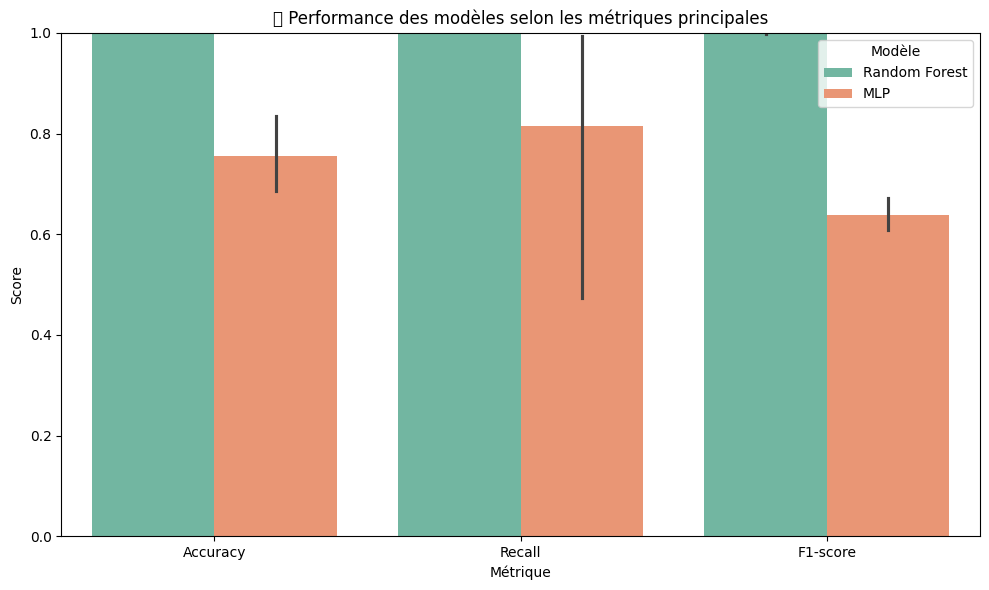

c:\Users\bamoi\OneDrive - Groupe ESAIP\$ PSIR\experimentation\repo\psir-ml-imputation\src\evaluation\visualization.py:37: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\bamoi\OneDrive - Groupe ESAIP\$ PSIR\experimentation\repo\psir-ml-imputation\src\evaluation\visualization.py:40: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300)


✅ Barplot sauvegardé dans results/barplot_performances.png


C:\Users\bamoi\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


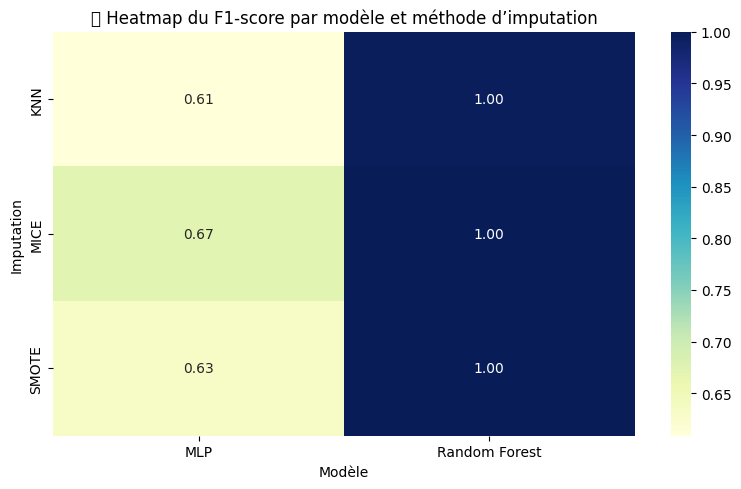

✅ Heatmap sauvegardée dans results/heatmap_f1score.png


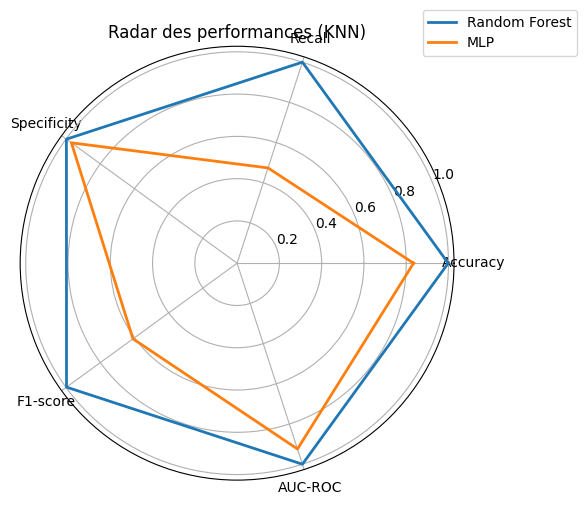

✅ Radar chart sauvegardé : results/radar_KNN.png


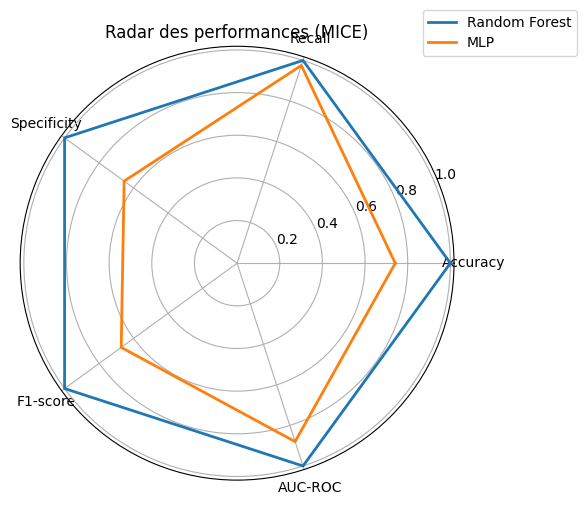

✅ Radar chart sauvegardé : results/radar_MICE.png


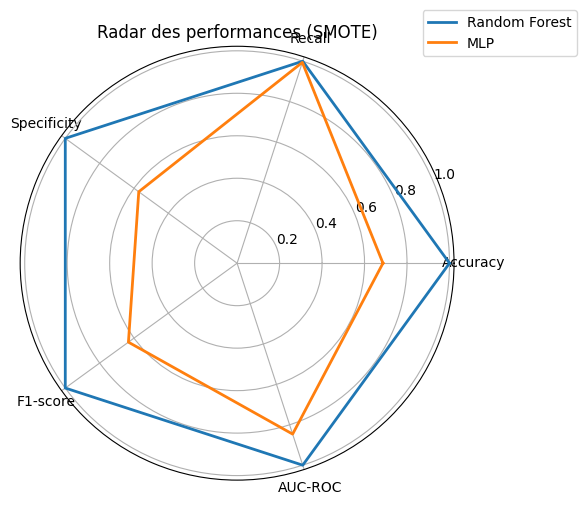

✅ Radar chart sauvegardé : results/radar_SMOTE.png

🎯 Exécution terminée avec succès.
📁 Résultats globaux : results/performances.csv
📊 Visualisations disponibles dans le dossier : results/


In [43]:
if __name__ == "__main__":
    print("🚀 Démarrage du pipeline complet d’évaluation...\n")

    # ▶️ Lancer l’expérimentation complète
    df_resultats = executer_experimentation()

    print("\n📊 Génération des visualisations...")

    # 📁 Assurer la présence du dossier pour les graphiques
    os.makedirs("results", exist_ok=True)

    # 📉 1. Barplot comparatif des principales métriques (Accuracy, Recall, F1)
    plot_bar_metrics(
        df_resultats,
        save_path="results/barplot_performances.png"
    )
    print("✅ Barplot sauvegardé dans results/barplot_performances.png")

    # 🔥 2. Heatmap des F1-scores par modèle et méthode d’imputation
    plot_heatmap(
        df_resultats,
        save_path="results/heatmap_f1score.png"
    )
    print("✅ Heatmap sauvegardée dans results/heatmap_f1score.png")

    # 🕸️ 3. Radar charts pour chaque méthode d’imputation
    for methode in df_resultats["Imputation"].unique():
        radar_path = f"results/radar_{methode}.png"
        plot_radar(df_resultats, imputation=methode, save_path=radar_path)
        print(f"✅ Radar chart sauvegardé : {radar_path}")

    # ✅ Rapport final
    print("\n🎯 Exécution terminée avec succès.")
    print("📁 Résultats globaux : results/performances.csv")
    print("📊 Visualisations disponibles dans le dossier : results/")

